In [ ]:
from jax import grad
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random


In [ ]:
# Creating the pdf of normal distribution
data = np.arange(-3,3,0.01)
pdf = norm.pdf(data , loc = 0 , scale = 1)

In [ ]:
gaussian_score = grad(norm.logpdf)

In [ ]:
jnp.asarray([0.0])

DeviceArray([0.], dtype=float32)

In [ ]:
#Attention: one decimal place
gaussian_score(jnp.asarray([.0]))

TracerArrayConversionError: ignored

In [ ]:
def get_dlogp(x):
  n = len(x)
  list = []
  for i in range(0,n):
    grad = np.array(gaussian_score(x[i]))
    list = np.append(list,[grad])
  
  return list

In [ ]:
x = get_dlogp(data)

In [ ]:
#Plotting the Results
plt.plot(data, x , color = 'red')
plt.xlabel('Data points')
plt.ylabel('Score functions values')

In [ ]:
from jax import random

key = random.PRNGKey(44)

true_mu = 5.3
true_sigma = 2.1

data = random.normal(key,shape=(1000,1)) * true_sigma + true_mu
data[0:5]

DeviceArray([[0.72608757],
             [7.1064787 ],
             [1.9587264 ],
             [6.2289076 ],
             [5.808235  ]], dtype=float32)

In [ ]:
data.mean(),data.std()

(DeviceArray(5.297202, dtype=float32), DeviceArray(2.1414611, dtype=float32))

In [ ]:
!pip install Equinox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 5.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1


In [ ]:
from functools import partial

import equinox as eqx
from jax import jacfwd
from jax import numpy as np
from jax import vmap
from jax.scipy.stats import norm

class GaussianModel(eqx.Module):
    """Univariate Gaussian score function."""

    mu: np.array = np.array(0.0)
    log_sigma: np.array = np.array(0.0)

    @eqx.filter_jit
    def __call__(self, x):
        """Forward pass.

        :param x: Data. Should be of shape (1, :),
            where `1` is in the batch dimension slot.
            as the model is intended to be vmapped over batches of data.
        :returns: Score of a Gaussian conditioned on a `mu` and `log_sigma`.
        """

        #Jacobian instead of grad
        gaussian_score_func = jacfwd(norm.logpdf)
        return gaussian_score_func(x, loc=self.mu, scale=np.exp(self.log_sigma))

In [ ]:
def GaussianModel_my(x,mu,log_sigma):
  gaussian_score_function = jacfwd(norm.logpdf)
  return gaussian_score_function(x,loc=mu,scale=np.exp(log_sigma))

In [ ]:
gaussian_model = GaussianModel()

gaussian_model(-3.0)

DeviceArray(3., dtype=float32, weak_type=True)

In [ ]:
GaussianModel_my(-3.0,0,0)

In [ ]:
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 11.3 MB/s eta 0:00:00


In [ ]:
"""Training loop defined here."""
from typing import Callable, List, Tuple

import equinox as eqx
import optax
from jax import numpy as np
from tqdm.auto import tqdm


def fit(
    model: eqx.Module,
    data: np.ndarray,
    loss: Callable,
    optimizer: optax.GradientTransformation,
    steps: int = 1_000,
    progress_bar: bool = True,
) -> Tuple[eqx.Module, List]:
    """Fit model to data.
    :param model: An Equinox Module.
    :param data: Data to fit to of shape (batch, :)
    :param loss: Loss function.
    :param optimizer: The optimizer to use.
    :param steps: Number of steps to train for.
    :param progress_bar: Whether or not to show a progress bar.
        Defaults to True.
    :returns: A tuple of updated model + training loss history.
    """
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    dloss = eqx.filter_jit(eqx.filter_value_and_grad(loss))

    @eqx.filter_jit
    def step(model, data, opt_state):
        """One step of training loop.
        This closure is jitted to make training run really fast.
        :param model: An Equinox Module.
        :param data: Data to fit to of shape (batch, :)
        :param opt_state: State of optimizer.
        :returns: Stuff. (TODO)
        """
        loss_score, grads = dloss(model, data)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_score

    loss_history = []
    iterator = range(steps)
    if progress_bar:
        iterator = tqdm(iterator)
    for _ in iterator:
        model, opt_state, loss_score = step(model, data, opt_state)
        loss_history.append(loss_score)
    return model, loss_history

In [ ]:
import equinox as eqx
import jax.numpy as np
from jax import jacfwd, vmap


def score_matching_loss(model: eqx.Module, batch: np.ndarray) -> float:
    """Score matching loss function.
    This is taken from (Hyvärinen, 2005) (JMLR)
    and https://yang-song.github.io/blog/2019/ssm/.
    :param model: An Equinox Module.
    :param batch: A batch of data. Should be of shape (batch, :),
        where `:` refers to at least 1 more dimension.
    :returns: Score matching loss, a float.
    """

    #Jacobian of input model
    dmodel = jacfwd(model)

    # Jacobian of score function (i.e. dlogp estimator function).
    # In the literature, this is also called the Hessian of the logp.
    # (Recall that the Hessian is the 2nd derivative, while the Jacobian is the 1st.)
    # The Jacobian shape is: `(n,n)`,
    # where `n` is the number of dimensions of the input data,
    # or the number of random variables.
    # Here, we want the diagonals instead, which when extracted out, is of shape (i,)
    # Only extract diagonals means dy_i/dx_i
    term1 = vmap(dmodel)(batch)
    if len(term1.shape) == 2 and term1.shape[-1] == 1:
        term1 = np.expand_dims(term1, -1)
    term1 = vmap(np.diagonal)(term1)

    # Discretized integral of score function.
    term2 = 0.5 * vmap(model)(batch) ** 2
    term2 = np.reshape(term2, term1.shape)

    # Summation over the inner term, by commutative property of addition,
    # automagically gives us the trace of the Jacobian of the score function.
    # Yang Song's blog post refers to the trace
    # (final equation in the section
    # "Learning unnormalized models with score matching"),
    # while Hyvärinen's JMLR paper uses an explicit summation in Equation 4.
    inner_term = term1 + term2
    summed_by_dims = vmap(np.sum)(inner_term)
    return jnp.mean(summed_by_dims)

In [ ]:
def score_matching_loss_my(model,data):
  dmodel = jacfwd(model)
  term1 = dmodel(data)

  return term1

In [ ]:
optimizer = optax.adam(learning_rate=5e-3)
updated_model, loss_history = fit(
    gaussian_model, 
    data, 
    score_matching_loss, 
    optimizer, 
    steps=2_000, 
    progress_bar=False
)

In [ ]:
import seaborn as sns

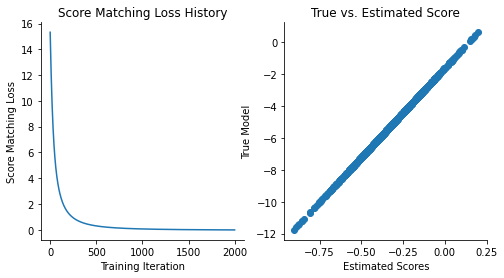

In [ ]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)


plt.sca(axes[0])
plt.plot(loss_history)
plt.xlabel("Training Iteration")
plt.ylabel("Score Matching Loss")
plt.title("Score Matching Loss History")
sns.despine()

plt.sca(axes[1])
updated_model_scores = vmap(updated_model)(data)
true_model_scores = vmap(gaussian_model)(data)
plt.scatter(updated_model_scores.squeeze(), true_model_scores.squeeze())
plt.xlabel("Estimated Scores")
plt.ylabel("True Model")
plt.title("True vs. Estimated Score")
sns.despine()

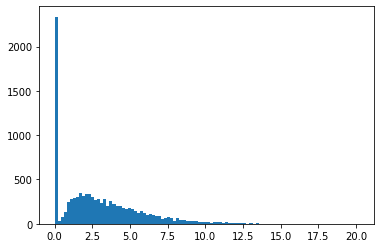

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def tweedie(n,p,mu,phi):
    #checking the value of variance power between 1-2
    result = np.full(n, np.nan)
    # calculating mean of poisson distribution
    lambdaa = mu ** (2 - p) / (phi * (2 - p))
    # shape parameter of gamma distribution
    alpha = (2 - p) / (1 - p)
    # scale parameter of gamma distribution
    gam = phi * (p - 1) * ( mu ** (p - 1))
    # Generating Poisson random sample
    rs = np.random.poisson(lambdaa, n)
    for i in range(n):
    # Generate single data point of gamma distribution using poisson random variable
        result[i] = np.random.gamma(rs[i] * np.abs(alpha), gam, 1)
    return result

x = tweedie(10000, 1.2, 3, 2)
plt.hist(x, bins=100)
plt.show()

In [ ]:
import jax

x = x.reshape(10000,1)
x = jax.numpy.asarray(x)

In [ ]:
class MixtureGaussian(eqx.Module):
    """Mixture Gaussian score function."""

    mus: np.array
    log_sigmas: np.array
    ws: np.array

    def __init__(self, mus, log_sigmas, ws):
        self.mus = mus
        self.log_sigmas = log_sigmas
        self.ws = ws

        # Check that mus, log_sigmas, and ws are of the same length.
        lengths = set(map(len, [mus, log_sigmas, ws]))
        if len(lengths) != 1:
            raise ValueError(
                "`mus`, `log_sigmas` and `ws` must all be of the same length!"
            )

    @eqx.filter_jit
    def __call__(self, x):
        """Forward pass.

        :param x: Data. Should be of shape (1, :),
            where `1` is in the batch dimension slot.
            as the model is intended to be vmapped over batches of data.
        :returns: Score of a Gaussian conditioned on a `mu` and `log_sigma`.
        """
        return partial(
            dmixture_logpdf,
            mus=self.mus,
            sigmas=np.exp(self.log_sigmas),
            ws=self.ws,
        )(x)

def mixture_pdf(x, mus, sigmas, ws):
    """Mixture likelihood.
    :param x: Data. Should be of shape (1, :),
        as the model is intended to be vmapped over batches of data.
    :param mus: Mixture component locations.
    :param sigmas: Mixture component scales.
    :param ws: Mixture component weights.
    :returns: The likelihood of a mixture PDF evaluated at `x`.
    """
    component_pdfs = vmap(partial(norm.pdf, x))(mus, sigmas)  # 2, n_draws)
    scaled_component_pdfs = vmap(np.multiply)(component_pdfs, ws)
    total_pdf = np.sum(scaled_component_pdfs, axis=0)
    return total_pdf


def mixture_logpdf(x, mus, sigmas, ws):
    """Mixture loglikelihood.
    :param x: Data. Should be of shape (1, :),
        as the model is intended to be vmapped over batches of data.
    :param mus: Mixture component locations.
    :param sigmas: Mixture component scales.
    :param ws: Mixture component weights.
    :returns: The log likelihood of a mixture PDF evaluated at `x`.
    """
    return np.log(mixture_pdf(x, mus, sigmas, ws))


dmixture_logpdf = jacfwd(mixture_logpdf, argnums=0)

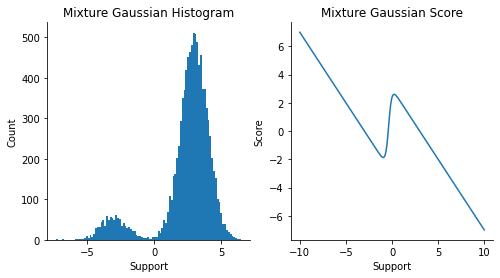

In [ ]:
import seaborn as sns 
import numpy as onp 

x = np.linspace(-10, 10, 200)
mus = np.array([-3, 3])
sigmas = np.array([1, 1])
ws = np.array([0.1, 0.9])

mgmodel = MixtureGaussian(mus, np.log(sigmas), ws)
mixture_logpdf_grads = vmap(mgmodel)(x)


fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

plt.sca(axes[0])
k1, k2 = random.split(random.PRNGKey(55))
draws = 1000
mix1 = random.normal(k1, shape=(1000,)) * 1 - 3
mix2 = random.normal(k2, shape=(9000,)) * 1 + 3
data = np.concatenate([mix1, mix2]).reshape(-1, 1)
plt.hist(onp.array(data), bins=100)
plt.title("Mixture Gaussian Histogram")
plt.xlabel("Support")
plt.ylabel("Count")
sns.despine()

plt.sca(axes[1])
plt.plot(x, mixture_logpdf_grads)
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("Mixture Gaussian Score")
sns.despine()

In [ ]:
from jax import nn
from jax import random

class FeedForwardModel1D(eqx.Module):
    """Feed-forward NN model."""

    mlp: eqx.Module

    def __init__(
        self,
        in_size=1,
        out_size=1,
        width_size=4096,
        depth=1,
        activation=nn.relu,
        key=random.PRNGKey(45),
    ):
        self.mlp = eqx.nn.MLP(
            in_size=in_size,
            out_size=out_size,
            width_size=width_size,
            depth=depth,
            activation=activation,
            key=key,
        )

    @eqx.filter_jit
    def __call__(self, x):
        """Forward pass.

        :param x: Data. Should be of shape (1, :),
            as the model is intended to be vmapped over batches of data.
        :returns: Estimated score of a Gaussian.
        """
        return self.mlp(x)

In [ ]:
"""Utility loss functions."""
from typing import Callable, Union

import equinox as eqx
import jax.numpy as np
from jax.tree_util import tree_flatten, tree_map


def l2_norm(
    model: Union[eqx.Module, Callable], batch: np.ndarray, scale: float = 0.1
) -> float:
    """Return the sum of square of weights.
    Allows for L2 norm-based regularization of weight parameter.
    Intended to be used as part of a loss function.
    Example:
    >>> from score_models.losses import l2_norm
    >>> param = [(0.5, 0.3), (0.1, -1.3)]
    >>> l2_norm(param)
    DeviceArray(2.0399997, dtype=float32)
    :param model: An Equinox Module.
    :param batch: Present only for compatibility with the rest of the loss functions.
    :param scale: The scale of L2 regularization to apply. Defaults to 0.1
    :returns: L2 norm.
    """
    # Test: tree-map np.sum to get weight regularization term
    model = eqx.filter(model, eqx.is_array_like)
    squared = tree_map(lambda x: np.power(x, 2), model)
    summed = tree_map(np.sum, squared)
    flattened, _ = tree_flatten(summed)
    return np.sum(np.array(flattened)) * scale


def chain(*loss_funcs):
    """Chain loss functions together.
    All loss funcs must have the signature loss(model, batch).
    :param loss_funcs: Loss functions to chain together.
    :returns: A closure.
    """

    def chained(model, batch):
        """Chained loss function.
        This loss simply adds up the losses computed by
        the loss functions defined in the outer function.
        :param model: Equinox model.
        :param batch: A batch of data.
        :returns: Total loss across all loss functions.
        """
        loss_score = 0
        for loss in loss_funcs:
            loss_score += loss(model, batch)
        return loss_score

    return chained

In [ ]:
regularized_loss = chain(
    l2_norm, 
    score_matching_loss
)

In [ ]:
ffmodel = FeedForwardModel1D(depth=2, width_size=512, activation=nn.softplus)
optimizer = optax.chain(
    optax.clip(0.0001),
    optax.sgd(learning_rate=5e-3),
)
updated_model, history = fit(
    ffmodel,
    data,
    score_matching_loss,
    optimizer,
    steps=5_000,
    progress_bar=True,
)

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

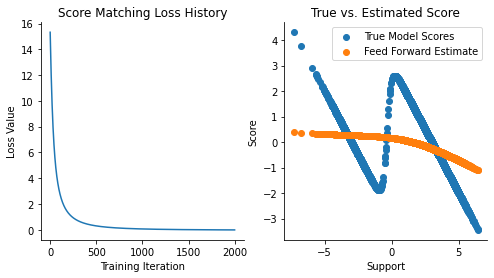

In [ ]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

plt.sca(axes[0])
plt.plot(loss_history)
plt.xlabel("Training Iteration")
plt.ylabel("Loss Value")
plt.title("Score Matching Loss History")
sns.despine()

plt.sca(axes[1])
true_model_scores = vmap(mgmodel)(data).squeeze()
updated_model_scores = vmap(updated_model)(data).squeeze()
plt.scatter(data.squeeze(), true_model_scores, label="True Model Scores")
plt.scatter(data.squeeze(), updated_model_scores, label="Feed Forward Estimate")
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("True vs. Estimated Score")
plt.legend()
sns.despine()

In [ ]:
ffmodel = FeedForwardModel1D(depth=2, width_size=512, activation=nn.relu)
optimizer = optax.chain(
    optax.clip(0.0001),
    optax.sgd(learning_rate=5e-3),
)
updated_model, history = fit(
    ffmodel,
    x,
    score_matching_loss,
    optimizer,
    steps=5_000,
    progress_bar=True,
)

  0%|          | 0/5000 [00:00<?, ?it/s]

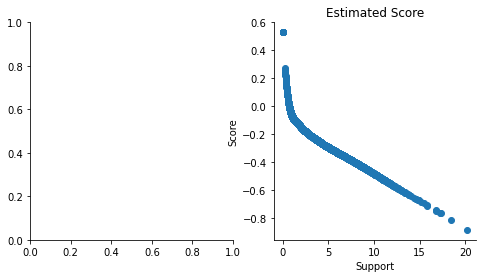

In [ ]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)



plt.sca(axes[1])
updated_model_scores = vmap(updated_model)(x).squeeze()
plt.scatter(x.squeeze(), updated_model_scores, label="Feed Forward Estimate")
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("Estimated Score")
sns.despine()

## Langevin dynamics

In [ ]:
from jax import random
import numpy as np

def langevin_dynamics_step(prev_x, score_func, epsilon, key):
    """One step of Langevin dynamics sampling."""
    draw = random.normal(key)
    new_x = prev_x + epsilon * score_func(prev_x) + np.sqrt(2 * epsilon) * draw
    return new_x

In [ ]:
from jax import jit, lax

class LangevinDynamicsChain(eqx.Module):
    """Langevin dynamics chain."""

    gradient_func: eqx.Module
    n_samples: int = 10000
    epsilon: float = 5e-3

    @eqx.filter_jit
    def __call__(self, x, key: random.PRNGKey):
        """Callable implementation for sampling.

        :param x: Data of shape (batch, :).
        :param key: PRNGKey for random draws.
        :returns: A tuple of final draw and historical draws."""

        def langevin_step(prev_x, key):
            """Scannable langevin dynamics step.

            :param prev_x: Previous value of x in langevin dynamics step.
            :param key: PRNGKey for random draws.
            :returns: A tuple of new x and previous x.
            """
            draw = random.normal(key, shape=x.shape)
            new_x = (
                prev_x
                + self.epsilon * vmap(self.gradient_func)(prev_x)
                + np.sqrt(2 * self.epsilon) * draw
            )
            return new_x, prev_x

        keys = random.split(key, self.n_samples)
        final_xs, xs = lax.scan(langevin_step, init=x, xs=keys)
        return final_xs, jnp.vstack(xs)

### Single chain sampling

In [ ]:
trained_model_sampler = LangevinDynamicsChain(gradient_func=updated_model, epsilon=5e-1)
key = random.PRNGKey(55)
final, trained_samples = trained_model_sampler(jnp.asarray([[2.0]]), key)

untrained_model_sampler = LangevinDynamicsChain(gradient_func=ffmodel, epsilon=5e-1)
final, untrained_samples = untrained_model_sampler(jnp.array([[2.0]]), key)

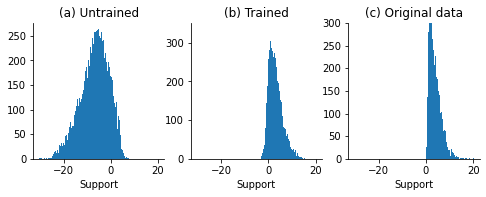

In [ ]:
fig, axes = plt.subplots(figsize=(8, 2.5), ncols=3, sharex=True)

plt.sca(axes[0])
plt.hist(np.array(untrained_samples), bins=100)
plt.title("(a) Untrained")
plt.xlabel("Support")

plt.sca(axes[1])
plt.hist(np.array(trained_samples), bins=100)
plt.title("(b) Trained")
plt.xlabel("Support")

plt.sca(axes[2])
plt.hist(np.array(x), bins=100)
plt.ylim((0,300))
plt.title("(c) Original data")
plt.xlabel("Support")

sns.despine()